## tf.data: 텐서플로우 입력 파이프라인 만들기
##### url: https://www.tensorflow.org/guide/data

- 목차
    - 기본 구조
        - 데이터셋 구조
    - 입력 데이터 불러오기
        - 넘파이 행렬 사용하기
        - 파이썬 제너레이터 사용하기
        - TFRecord 데이터 사용하기
        - 텍스트 데이터 사용하기
        - CSV 데이터 사용하기
        - 데이터 집합 사용하기
    - 데이터 원소 배치 만들기
        - 간단한 배치 만들기
        - 패딩과 함께 텐서 배치 만들기
    - 학습 흐름
        - 다중 에폭 수행하기
        - 입력 데이터를 임의로 섞기
    - 데이터 전처리
        - 이미지 데이터 복호화 및 리사이즈하기
        - 임의의 파이썬 함수 적용하기
        - tf.Example 프로토콜 버퍼 메시지 파싱하기
        - 시계열 윈도우 적용하기
        - 리샘플링
    - 고수준 API 사용하기
        - tf.keras
        - tf.estimator

`tf_data` API는 간단하고 재사용이 가능한 조각을 통해 복잡한 입력 파이프라인을 만들 수 있게 해줍니다.<br>
예를 들어 이미지 모델을 위한 파이프라인은 파일 시스템에 분산되어 있는 파일들을 모아주고, 각 이미지에 임의성을 부여하며 학습 배치로 사용될 선택된 이미지를 임의로 병합할 수 있습니다.<br>
텍스트 모델을 위한 파이프라인은 원본 텍스트 데이터에서 심볼을 추출하는 것을 포함해 룩업 테이블과 함께 임베딩 식별자로 변환하거나 서로 다른 길이를 가진 시퀀스로 배치를 만들 수 있습니다.<br>
`tf.data` API는 거대한 양의 데이터를 다룰 수 있게 만들어주며, 서로 다른 데이터 포맷을 읽거나 복잡한 변환을 수행할 수 있습니다.<br><br>
`tf.data` API는 하나 또는 그 이상의 컴포넌트로 구성된 각 원소의 시퀀스를 표현하는 `tf.data.Dataset` 추상화를 도입합니다. <br>
예를 들어, 이미지 파이프라인에서 이미지와 라벨로 표현된 텐서 컴포넌트의 쌍으로 원소들은 하나의 학습 샘플이 될 수 있습니다.

- 데이터 소스는 메모리에 저장되어 있거나 하나 또는 그 이상의 파일로 저장된 데이터로부터 `Dataset` 객체를 만듭니다.
- 데이터 변환은 하나 또는 그 이상의 `tf.data.Dataset` 객체로부터 데이터셋을 만듭니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## 기본 구조
입력 파이프라인을 만드려면, 반드시 데이터 소스와 함께 시작해야 합니다. <br>
예를 들어, 메모리 내의 데이터로부터 `Dataset`를 만들기 위해서는 `tf.data.Dataset.from_tensors()` 함수 또는 `tf.data.Dataset.from_tensor_slices()`함수를 사용할 수 있습니다.<br>
대안으로, 입력 데이터가 권장되는 TFRecord 포맷의 파일로 저장되어 있다면 `tf.data.TFRecordDataset()` 함수를 사용할 수 있습니다.<br><br>한번 `Dataset` 객체를 만들게 되면, `tf.data.Dataset` 객체의 연쇄 메소드를 통해 새로운 `Dataset`으로 변환할 수 있습니다.<br>
예를 들어, 단일 원소에 적용되는 `Dataset.map()` 함수와 다중 원소에 적용되는 `Dataset.batch()` 변환을 수행할 수 있습니다.<br><br>
`Dataset` 객체는 '파이썬 이터러블(Iterable)' 객체이기 때문에 각 원소를 for loop을 사용해 모델에 입력할 수 있습니다.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [5]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


아니면 직접적으로 `iter` 함수를 사용해 파이썬 이터레이터를 사용하고 `next` 함수를 사용해 원소를 소진 합니다.

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


대안으로 데이터셋 원소는 `reduce` 변환을 사용해 소진될 수 있으며, 해당 변환은 단일 결과를 생성하기위해 모든 원소를 압축합니다.<br>
다음 예제를 통해 데이터셋의 정수 합을 계산하는 `reduce` 변환이 어떻게 사용되는지 확인해보겠습니다.

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


#### 데이터셋 구조
데이터셋은 내재적으로 같은 구조를 가지고 있는 원소와 `Tensor`, `SparseTensor`, `ReggedTensor`, `TensorArray`, `Dataset`처럼 `tf.TypeSpec`에 의해 표현되는 타입 속성 구조를 가진 각각의 컴포넌트로 이루어져 있습니다.<br><br>
`Dataset.element_spec` 프로퍼티는 각 원소 컴포넌트의 타입을 검사할 수 있게 해줍니다. <br>
해당 프로퍼티는 원소의 구조를 매칭하기 위한 `tf.TypeSpec` 객체의 내부 내재된 구조를 반환하며 원소의 구조는 단일 컴포넌트, 튜플 컴포넌트 또는 내재된 튜풀 컴포넌트일 수도 있습니다.

In [8]:
# 단일 컴포넌트
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
# 튜플 컴포넌트
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
     tf.random.uniform([4, 100], maxval=100, dtype=tf.int32))
)

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
# 내재된 튜플 컴포넌트
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# 희소 텐서를 포함하는 데이터셋
dataset4 = tf.data.Dataset.from_tensors(
   tf.SparseTensor(indices=[[0, 0], [1, 2]],
                   values=[1, 2],
                   dense_shape=[3, 4]
                  )
)
dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# value_type를 사용해서 element spec에 의해 표현되는 값의 타입 살펴보기
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

`Dataset` 변환은 모든 구조의 데이터셋을 지원합니다. <br>
각 원소에 적용 되는 함수인 `Dataset.map()` 또는 `Dataset.filter()` 변환을 사용할 떄, 원소 구조는 함수의 인자로 결정됩니다.

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32)
)
dataset1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [14]:
for z in dataset1:
    print(z.numpy())

[3 1 2 4 5 1 6 9 8 3]
[3 2 3 3 5 6 5 9 4 4]
[3 6 4 3 8 4 5 7 8 9]
[9 9 7 3 1 5 7 6 5 1]


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
     tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)
    
    )
)

dataset2

<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [17]:
for a, (b, c) in dataset3:
    print(f'shapes: {a.shape}, {b.shape}, {c.shape}')

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## 입력 데이터 읽어오기
### 넘파이 행렬 읽어오기
더 많은 예제는 [Loading NumPy arrays](https://www.tensorflow.org/tutorials/load_data/numpy)를 확인하세요.<br><br>
만약 모든 입력 데이터가 메모리에 올라갈 수 있다면, `Dataset`을 만드는 가장 쉬운 방법은 `tf.Tensor` 객체로 변환하거나, `Dataset.from_tensor_slices()` 함수를 사용하는 것입니다.

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [19]:
images, labels = train
images = images/255.0

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

> Note: 위의 코드 스니펫은 변수(feature)와 라벨(label) 행렬을 `tf.constant()` 연산으로써 텐서플로우 그래프에 포함합니다. 이러한 작업은 작은 데이터셋에는 유용할 수 있으나, 여러번에 걸쳐 행렬의 내용을 복사하므로 메모리를 낭비할 수 있습니다. 그리고 2GB로 제한된 `tf.GraphDef` 프로토콜 버퍼의 크기에 도달할 수 있습니다.

#### 파이썬 제너레이터로 읽어오기
다른 `tf.data.Dataset`으로써 쉽게 수집될 수 있는 일반적인 데이터 소스는 파이썬 제너레이터가 있습니다.

> 주의: 이것은 이식성과 확장성을 제한할 수 있는 가장 편리한 접근 방법이지만, 이러한 작업은 반드시 제너레이터를 생성한 같은 파이썬 프로세스에서 실행되어야하며, 여전히 파이썬 GIL이 적용됩니다.

In [20]:
def count(stop):
    i = 0
    while i<stop :
        yield i
        i += 1

In [21]:
for n in count(5):
    print(n)

0
1
2
3
4


`Dataset.from_generator` 생성자는 파이썬 제너레이터를 완전히 함수적인 `tf.data.Dataset`으로 변환합니다.<br><br>
그 생성자는 입력으로써 iterator가 아닌 callable을 사용합니다. 이를 통해 제너레이터가 끝에 다다랐을 때 재시작될 수 있도록 합니다.<br>
선택적으로 callable의 인자로서 넘겨줄 수 있도록 `args` 인수를 사용할 수 있습니다.<br><br>
`output_types` 인수는 내부적으로 `tf.data`가 `tf.Graph`를 만들기 때문에 요구됩니다. 그리고 그래프 엣지는 `tf.dtype`을 요구합니다.

In [22]:
ds_counter = tf.data.Dataset.from_generator(count,
                                            args=[25],
                                            output_types=tf.int32,
                                            output_shapes = (), )

In [23]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


`outpyt_shapes` 인수는 요구되지 않습니다. 하지만 많은 텐서플로우 연산들이 알려지지 않은(unknown) 랭크를 지원하지 않기 때문에 입력하는 것을 강력히 권해드립니다.<br>
만약 특정한 축의 길이가 알려지지 않거나 또는 변할 수 있다면, `output_shape`에 `None` 을 세팅합니다.<br><br>
또한, `output_shapes`와 `output_types`는 다른 데이터 메소드와서도 동일한 중첩 규칙을 따른다는 것도 중요합니다.<br><br>
여기에 두 측면을 살펴볼 제너레이터 예제가 있습니다. 이 제너레이터는 행렬의 튜플을 반환하며, 두번째 행렬은 길이가 알려지지 않은 벡터입니다.

In [24]:
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0, 10)
        yield i, np.random.normal(size=(size,))
        i += 1

In [25]:
for i, series in gen_series():
    print(i, ':', str(series))
    if i > 5:
        break

0 : [-0.003   2.0399 -1.1207 -1.6822  0.3165 -0.5428  0.4409 -0.884  -0.5552]
1 : [-2.3921  1.6472  0.5304  1.4595 -0.5262  0.6986 -1.0117]
2 : [ 0.516  -0.3338  0.3633  0.3679 -0.9287  0.5517  0.7592 -0.1117 -0.8157]
3 : [ 0.2367 -1.0149 -0.4488 -0.6776  0.5602  1.1494  0.6948  1.1935  1.1891]
4 : [0.3232 0.7227]
5 : []
6 : [-0.6557 -1.0836 -0.6212 -1.2704]


첫 번째 출력 값은 `int32`이고, 두 번째 값은 `float32`<br><br>
첫 번째 아이템은 `()` 차원의 스칼라이며, 두 번째는 알려지지 않은 길이인 `(None, )`차원의 벡터 입니다.

In [26]:
ds_series = tf.data.Dataset.from_generator(
    gen_series,
    output_types=(tf.int32, tf.float32),
    output_shapes=((), (None)))

ds_series

<DatasetV1Adapter shapes: ((), <unknown>), types: (tf.int32, tf.float32)>

이제 일반적인 `tf.data.Dataset`처럼 사용될 수 있습니다. 변화할 수 있는 차원을 가진 데이터셋을 배치로 만들 때, `Dataset.padded_batch`를 사용할 필요가 있습니다.

In [27]:
# padded_batch를 사용해서 배치 사이즈를 통해 일정한 길이로 맞춰줄 수 있습니다.
ds_series_batch = ds_series.shuffle(20).padded_batch(10, padded_shapes=([], [None]))

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy(), end='\n\n')
print(sequence_batch.numpy())

[ 9  5 17  6 16  0 18 23  7  4]

[[-2.3081  0.2847  1.3778 -1.6385 -1.5686 -1.4005  0.      0.      0.    ]
 [ 0.7483 -0.9878 -0.6766  0.1991  0.      0.      0.      0.      0.    ]
 [-1.4379  0.4422 -1.8337 -0.1906  0.      0.      0.      0.      0.    ]
 [ 0.3492 -0.623   1.2094 -0.06   -0.5485  1.709   0.      0.      0.    ]
 [ 0.8604 -0.9514  1.5438 -0.6315  0.3302  0.6698 -0.5048  0.6229 -0.581 ]
 [-1.3392 -0.3271  1.2879 -1.4358 -2.126  -0.6623  0.      0.      0.    ]
 [ 0.4506  1.8456  0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.7941  1.8196  0.4039 -0.518   0.0491 -0.6021 -0.974   0.      0.    ]
 [-0.2075 -0.1675  0.4762  0.5958 -1.1761  0.987   0.      0.      0.    ]
 [-0.1657  1.1052 -0.1298  0.      0.      0.      0.      0.      0.    ]]


더 현실적인 예제로, `tf.data.Dataset`로써 `preprocessing.image.ImageDataGenerator`로 래핑을 시도해보겠습니다.<br><br>
먼저 데이터를 다운받습니다.

In [28]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

`image.ImageDataGenerator`를 생성합니다.

In [29]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [30]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [31]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [32]:
ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, 
    args=[flowers],
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds

<DatasetV1Adapter shapes: ((32, 256, 256, 3), (32, 5)), types: (tf.float32, tf.float32)>

### TFRecord 데이터 사용하기

End-to-end 예제는 [Loading TFRecords](https://www.tensorflow.org/tutorials/load_data/tf_records)를 살펴보세요.<br><br>
`tf.data` API는 다양한 파일 포맷을 지원합니다. 그래서 데이터 셋이 메모리에 전부 적재되지 않더라도 크기가 큰 데이터셋을 처리할 수 있습니다.<br>
예를 들어, TFRecord 파일 포맷은 많은 텐서플로우 어플리케이션이 학습 데이터에 사용하는 간단한 레코드-지향 이진 포맷입니다.<br>
`tf.data.TFRecordDataset` 클래스는 입력 파이프라인의 일부로써 하나 또는 그 이상의 TFRecord 파일의 컨텐츠를 스트림할 수 있도록 해줍니다.<br><br>
French Street Name Signs(FSNS) 데이터셋의 테스트 파일을 사용한 예제를 살펴보겠습니다.

In [33]:
# 두 개의 파일의 예제의 전부를 불러와 데이터셋을 생성합니다.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", 
                                         "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

`tf.data.TFRecordDataset`의 `filename` 인자는 문자열이거나 문자열의 리스트 또는, `tf.Tensor` 문자열일 수도 있습니다.<br>
그러므로 학습과 검증의 목적으로 두개로 이루어진 파일을 가지고 있다면, 입력 인자로써 파일 이름을 사용해 데이터셋을 생성하기 위한 팩토리 메소드를 생성할 수 있습니다.

In [34]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

많은 텐서플로우 프로젝트는 TFRecord 파일에 있는 직렬화된 `tf.train.Example` 레코드를 사용합니다.<br>
해당 레코드들은 확인되기 전에, 복호화가 필요합니다.

In [35]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### 텍스트 데이터 사용하기

End-to-End 예제는 [Loading Text](https://www.tensorflow.org/tutorials/load_data/text)를 살펴보세요.<br><br>
많은 데이터셋이 하나 또는 그 이상의 텍스트 파일로 분산되어 있습니다.<br>
`tf.data.TextLineDataset`은 하나 또는 이상의 텍스트 파일로부터 행을 추출하는 가장 쉬운 방법을 제공합니다을<br>
하나 또는 더 많은 파일 이름이 주어지면, `TextLineDataset`은 해당 파일의 행 당 하나의 문자열-값 원소를 생성하게됩니다.

In [36]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name) for file_name in file_names
]

In [37]:
dataset = tf.data.TextLineDataset(file_paths)

첫 번째 파일의 앞의 몇 행을 확인해보겠습니다.

In [38]:
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


여러 파일들 사이에서 행이 번갈아 일어나도록 `Dataset,interleave` 함수를 사용합니다.<br>
이는 파일이 손쉽게 섞일 수 있도록 만들어줍니다.<br>

In [39]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
    if i % 3 == 0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


기본 값으로 `TextLineDataset`은 각 파일의 모든 행을 생성하므로 파일이 주석을 포함하고 있거나 헤더 라인부터 시작된다면, 이는 바람직하지 않을 수 있습니다.<br>
그런 행들은 `Dataset.skip()` 또는 `Dataset.filter()` 변환을 사용하여 제거할 수 있습니다.<br>
첫 번째 행을 건너뛰고 생존자만을 필터링하겠습니다.

In [40]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [41]:
for line in titanic_lines.take(10):
    print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [42]:
def survived(line):
    return tf.not_equal(tf.strings.substr(line, 0, 1), '0')

survivors = titanic_lines.skip(1).filter(survived)

In [43]:
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### CSV 데이터 사용하기
더 많은 예제는 [Loading CSV Files](https://www.tensorflow.org/tutorials/load_data/csv)와 [Loading Pandas DataFrames](https://www.tensorflow.org/tutorials/load_data/pandas)를 확인하세요.<br><br>

CSV는 일반 텍스트로 이루어진 정형 데이터를 저장하기 위한 인기있는 파일 포맷입니다. <br>

In [44]:
titanic_file = tf.keras.utils.get_file("train.csv", 
                                       "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [45]:
df = pd.read_csv(titanic_file, index_col=None)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


만약 데이터 파일을 모두 메모리에 적재할 수 있다면, 동일한 `Dataset.from_tensor_slices` 메소드에 딕셔너리 형태로 전달하여 작동시킵니다.<br>
이는 데이터를 쉽게 불러올 수 있도록 해줍니다.

In [46]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print('   {!r:20s}: {}'.format(key, value))

   'survived'          : 0
   'sex'               : b'male'
   'age'               : 22.0
   'n_siblings_spouses': 1
   'parch'             : 0
   'fare'              : 7.25
   'class'             : b'Third'
   'deck'              : b'unknown'
   'embark_town'       : b'Southampton'
   'alone'             : b'n'


더욱 확장성있는 접근 방법은 필요할 때 디스크에서 불러오는 방법이 있습니다.<br><br>
`tf.data` 모듈은 `RFC 4180`을 따르는 하나 또는 그 이상의 CSV 파일로부터 레코드를 추출하는 메소드를 제공합니다.<br><br>
`experimental.make_csv_dataset` 함수는 CSV 파일 집합을 읽기 위한 고수준 인터페이스입니다. <br>
해당 함수는 열 타입의 추론과 배치 만들기, 섞기 등 많은 기능들을 제공하여 사용하기에 간편합니다. 

In [47]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name='survived'
)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [48]:
for feature_batch, label_batch in titanic_batches.take(1):
    print(f"'survived' : {label_batch}")
    print('features')
    for key, value in feature_batch.items():
        print('    {!r:20s}: {}'.format(key, value))

'survived' : [0 0 0 0]
features
    'sex'               : [b'male' b'male' b'male' b'male']
    'age'               : [31. 50. 28. 25.]
    'n_siblings_spouses': [0 0 0 0]
    'parch'             : [0 0 0 0]
    'fare'              : [ 10.5     13.     227.525    7.8958]
    'class'             : [b'Second' b'Second' b'First' b'Third']
    'deck'              : [b'unknown' b'unknown' b'unknown' b'unknown']
    'embark_town'       : [b'Southampton' b'Southampton' b'Cherbourg' b'Southampton']
    'alone'             : [b'y' b'y' b'y' b'y']


특정한 컬럼들의 부분 집합이 필요하다면, `select_columns` 인자를 사용할 수 있습니다.

In [49]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name='survived', select_columns=['class', 'fare', 'survived']
)

In [50]:
for feature_batch, label_batch in titanic_batches.take(1):
    print(f"'survived': {label_batch}")
    for key, value in feature_batch.items():
        print('    {!r:20s}: {}'.format(key, value))

'survived': [0 0 0 0]
    'fare'              : [ 0.     25.4667 33.     26.    ]
    'class'             : [b'Third' b'Third' b'Second' b'Second']


더욱 세분화된 제어를 제공하는 저수준 `experimental.CsvDataset` 클래스가 있습니다.<br>
해당 클래스는 열 타입 추론을 제공하지는 않습니다. 대신에 각 열에 대한 타입을 반드시 명확히 해야합니다.

In [51]:
# 이런 방식으로 각 열의 타입을 명확하게 해야합니다.
titanic_types = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string,
                 tf.string, tf.string, tf.string]
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types, header=True)

for line in dataset.take(10):
    print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


몇몇의 열이 비어있다면, 이 저수준 인터페이스는 열 타입 대신 기본 값을 제공할 수 있도록 해줍니다.

In [52]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Overwriting missing.csv


In [53]:
# 두개의 CSV 파일 레코드를 읽어 데이터셋을 생성합니다.
# 각각 4개의 실수 열이 있으며, 결측값을 가지고 있을 수 있습니다.

record_defaults = [999, 999, 999, 999]
dataset = tf.data.experimental.CsvDataset('missing.csv', record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (4,), types: tf.int32>

In [54]:
for line in dataset:
    print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


기본 값으로, `CsvDataset`은 파일의 모든 행에 대한 모든 컬럼을 생성합니다. 이는 파일이 헤더나 입력으로 요구되지 않는 컬럼으로 시작될 경우에 바람직하지 않을 수도 있습니다.<br>
이러한 행들들과 필드는 `header`와 `select_cols` 인수로 각각 제거할 수 있습니다.

In [55]:
# 두개의 CSV 파일 레코드를 읽어 데이터셋을 생성합니다.
# 헤더와 2, 4번째 열의 데이터를 추출합니다.
record_defaults = [999, 999]
dataset = tf.data.experimental.CsvDataset('missing.csv',
                                          record_defaults,
                                          select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (2,), types: tf.int32>

In [56]:
for line in dataset:
    print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### 파일 집합 사용하기
파일의 집합으로서 많은 데이터셋이 분산되어 있습니다. 각 파일은 데이터 샘플 입니다.

In [57]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

flowers_root = pathlib.Path(flowers_root)

> 해당 이미지들은 CC-BY에 라이선스 되어있습니다. 상세한 내용은 LICENCE.txt 를 확인하세요

In [58]:
for item in flowers_root.glob('*'):
    print(item.name)

roses
sunflowers
daisy
dandelion
tulips
LICENSE.txt


각 클래스 디렉토리의 파일은 데이터 샘플 입니다.

In [59]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/Users/kyle/.keras/datasets/flower_photos/dandelion/8740218495_23858355d8_n.jpg'
b'/Users/kyle/.keras/datasets/flower_photos/daisy/6089825811_80f253fbe1.jpg'
b'/Users/kyle/.keras/datasets/flower_photos/dandelion/18232119726_cef27eaaac_n.jpg'
b'/Users/kyle/.keras/datasets/flower_photos/tulips/443600168_cb08d56511.jpg'
b'/Users/kyle/.keras/datasets/flower_photos/daisy/367020749_3c9a652d75.jpg'


`tf.io.read_file` 함수를 사용하여 데이터를 읽을 수 있고, 경로로부터 라벨을 추출하여 `(image, label)`쌍을 반환합니다.

In [60]:
def process_path(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [61]:
for image_raw, label_text in labeled_ds.take(1):
    print(repr(image_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00'

b'dandelion'


## 데이터셋 원소 배치 만들기
### 간단한 배치만들기
가장 간단한 형태의 배치는 데이터 셋의 연속적인 `n`개의 원소를 쌓아 하나의 원소로 만드는 것 입니다. `Dataset.batch()` 변환은 명확하게 <br>
`tf.stack()` 연산과 같은 제약조건을 가지며 각 컴포넌트의 원소에 적용됩니다.<br>
예를 들어 컴포넌트 i에 대해 모든 원소들은 반드시 정확하게 같은 차원을 가진 텐서가 있어야합니다.

In [62]:
inc_dataset     = tf.data.Dataset.range(100)
dec_dataset     = tf.data.Dataset.range(0, -100, -1)
dataset         = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


`tf.data`가 차원 정보 전파를 시도하는 동안에 `Data.batch`의 기본 설정 값은 알려지지 않은(unknown) 배치 사이즈를 결과로 내놓습니다.<br>
이는 마지막 배치의 일부가 비어있을 수 있기 때문입니다. 차원에 `None`이 있는 것을 확인하세요

In [63]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

`drop_remainder` 인자를 사용하여 마지막 배치를 무시하고, 전체 차원 전파를 수행하세요.

In [64]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

### 패딩을 추가하여 텐서 배치 만들기
상기 방법은 같은 크기를 갖는 모든 텐서들을 위해 작동했습니다. 하지만, 많은 모델들은(예시, Sequence models) 다양한 크기를 가질 수 있는 입력 데이터로 작동됩니다.<br>
이러한 경우를 다루기 위해, `Dataset.padded_batch()` 변환은 패딩을 추가하는 것으로 하나 또는 많은 차원을 지정하며, 다른 차원의 텐서로 배치를 만들 수 있도록 합니다.

In [65]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None, ))

for batch in dataset.take(2):
    print(batch.numpy())
    print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



`Dataset.padded_batch()` 변환은 각 차원의 각 컴포넌트에 대해 다른 패딩을 부여할 수 있습니다. 그리고 고정 길이이거나 가변 길이가 될 수 있습니다.<br>
패딩 값을 재정의 하는 것도 가능합니다. 기본 값은 0 입니다.

## 학습 워크 플로우
### 다중 에폭 처리하기
`tf.data` API는 같은 데이터의 다중 에폭을 처리할 주요 2가지 방법을 제공합니다.<br><br>
다중 에폭에서 데이터셋을 반복하는 가장 쉬운 방법은 `Dataset.repeat()` 변환을 사용하는 것 입니다. 먼저 타이타닉 데이터셋을 생성해보겠습니다.

In [66]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titatinc_lines = tf.data.TextLineDataset(titanic_file)

In [67]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

아무 인자도 없이 `Dataset.repeat()` 변환을 적용하는 것은 입력 데이터셋을 무제한으로 반복하도록 합니다.<br><br>
`Dataset.repeat` 변환은 한 에폭과 다음 에폭의 시작을 알리지 않고 인수를 연결합니다.<br>
`Dataset.repeat` 이후에 적용된 `Dataset.batch`는 에폭의 경계를 넘는 배치를 생성합니다.

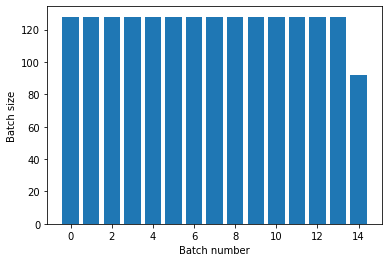

In [68]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

만약 에폭의 명확한 분리가 필요하다면, `Dataset.batch`를 repeat 이전에 적용하세요.

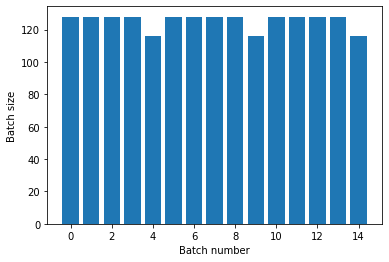

In [69]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

만약 각 에폭의 마지막에서 사용자 지정 계산(통계 수집)을 수행하고 싶다면, 각 에폭의 데이터 셋 반복을 재시작하는 것이 가장 간단합니다.

In [70]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print('End of epoch: ', epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


## 입력 데이터를 임의로 섞어보기

`Dataset.shuffle()` 변환은 고정된 크기의 버퍼를 유지하고, 버퍼로부터 임의로 같은 확률로 다음 원소를 선택합니다.

> Note: 큰 버퍼 사이즈는 더욱 철저하게 섞을 수 있지만, 많은 메모리가 소요될 수 있고 버퍼를 모두 채우기에 상당한 시간이 소요될 수 있습니다.
이러한 문제가 생긴다면, 파일간 <U>Dataset.interleave</U> 함수를 사용하는것을 고려해야 합니다.

데이터셋에 인덱스를 추가해 어떤 효과가 있는지 살펴보겠습니다.

In [71]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

`buffer_size`가 100이고, 배치 사이즈가 20이기 때문에, 첫번째 배치는 인덱스가 120을 넘는 원소를 갖지 않습니다.

In [72]:
n, line_batch = next(iter(dataset))
print(n.numpy())

[ 69  79  73  43  41  57 104  67  15  89 103  17  26  30  72  55  21  47
 108  58]


`Dataset.batch`와 마찬가지로, `Dataset.repeat`에 관련된 순서가 중요합니다.<br><br>
`Dataset.shuffle`은 셔플 버퍼에 아무것도 남아있지 않을 때까지 에폭의 마지막에 신호를 보내지 않습니다. 그래서 `repeat()` 이전에 위치된 `shuffle()`은 다음으로 이동하기 이전에 한 에폭의 모든 원소를 보여줍니다.

In [73]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print('에폭의 경계에 있는 아이템 ID:\n')
for n, line_batch in shuffled.skip(60).take(5):
    print(n.numpy())

에폭의 경계에 있는 아이템 ID:

[474 582 459 618 422 452 463 601 475 525]
[624 523 398 536 468 502 527 534 571 531]
[353 617 507 625 570 563 224 593]
[ 90  61  18  56   5  82  27  59  81 107]
[ 38  97  65  11  80  44 108 100 104  46]


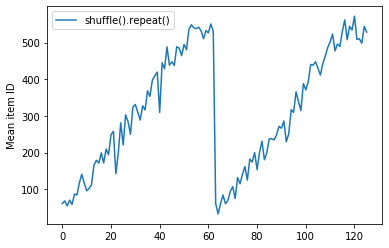

In [74]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label='shuffle().repeat()')
plt.ylabel('Mean item ID')
plt.legend()

하지만, `shuffle()` 이전에 위치한 `repeat()`은 에폭의 경계를 서로 섞는 결과를 보여줍니다.

In [75]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print('에폭의 경계에 있는 아이템 ID:\n')
for n, line_Batch in shuffled.skip(55).take(15):
    print(n.numpy())

에폭의 경계에 있는 아이템 ID:

[  5 526 575 462 621  26  25 619 548 544]
[498 536 481 597 373 618 600 483  23 509]
[ 41 616 339 625 358  33   1  24  11  18]
[549 413 603  27 589 522  55  47 582  34]
[ 49 588 598 581 576  30  66  28 615 464]
[ 45 465  51  19 608 613 620  75 599 611]
[ 71 626  79 579 172 609  42  69  63 572]
[521 607  59 584  12 546 466  50  86  78]
[ 61 532  91  56 577 583  82  95   8 109]
[523 513  99  54  81 106 104 514 429 506]
[ 32  87  70 502 545 114 124  36  68  35]
[539  29 131 542  98 552 617  65  57 482]
[555 622  77  92 115 103 111  76 105  22]
[137  31  73 129 480  64 142 591   9 144]
[ 39 126  67  43 154  88  37 602 593 102]


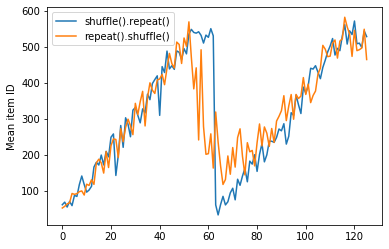

In [76]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label='shuffle().repeat()')
plt.plot(repeat_shuffle, label='repeat().shuffle()')
plt.ylabel('Mean item ID')
plt.legend()

## Preprocessing data
`Dataset.map()` 변환은 각 입력 데이터셋 원소에 주어진 함수 `f`를 적용하여 새로운 데이터셋을 생성합니다. <br>
함수형 프로그래밍 언어에서 리스트나 다른 자료구조에 일반적으로 적용되던 `map()` 함수에 기반을 두고 있습니다.<br>
함수 `f`는 입력 데이터의 단일 원소를 표현하는 `tf.Tensor` 객체를 입력으로 새로운 데이터셋의 단일 원소로 표현될 `tf.Tensor` 객체를 반환합니다.<br>
이 함수의 구현은 하나의 원소를 다른 것으로 변환하는 표준 텐서플로우 연산을 사용하였습니다.<br><br>
이 섹션에서는 `Dataset.map()` 함수를 어떻게 사용하는지 일반적인 예제로 알아보겠습니다.<br><br>

### 이미지 데이터 복호화 및 크기 조정하기
현실 세계의 이미지 데이터를 가지고 신경망을 학습할 때, 다른 크기에서 일반적인 크기로 변환하는 것이 종종 필요한 경우가 있습니다.<br>
그러므로 해당 이미지들은 고정된 크기를 가진 배치로 만들어질 수도 있습니다.<br><br>
the flower filename 데이터셋을 다시 살펴보겠습니다.

In [77]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

데이터 셋의 원소를 조작하기 위한 함수를 작성합니다.

In [78]:
# 파일로부터 이미지를 읽습니다, 해당 이미지를 밀집한 텐서로 복호화 합니다. 그리고 고정된 크기로 조정합니다.
def parse_image(filename):
    parts = tf.strings.split(filename, '/')
    label = parts[-2]
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

작동하는지 테스트 합니다.

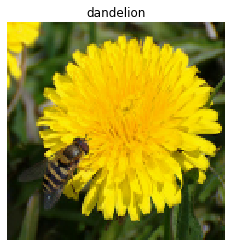

In [79]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')
    
show(image, label)

모든 데이터셋에 맵 함수를 적용합니다.

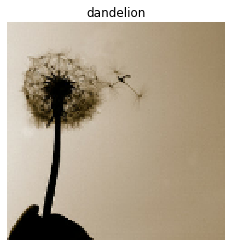

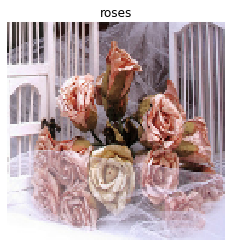

In [80]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
    show(image, label)

## 임의의 파이썬 로직 적용하기
성능상의 이유로, 가능한한 데이터의 전처리를 위해 텐서플로우 연산을 사용해야합니다. <br>
하지만, 때때로 입력 데이터를 파싱할 때 외부의 파이썬 라이브러리를 호출하는 것이 유용할 때가 있습니다.<br>
`Dataset.map()` 변환 내부에서 `tf.py_function()` 연산을 사용할 수 있습니다.<br><br>
예를 들어 당신이 데이터에 임의적으로 회전을 적용하길 원하는 상황에, `tf.image` 모듈이 `tf.image.rot90` 함수만을 지원한다면, <br>
해당 함수는 이미지 증가(Augmentation)에 매우 유용하지 않습니다.

> Note: **Tensorflow_addons**는 텐서플로우에 호환되는 **tensorflow_addons.image.rotate** 회전 함수를 가지고 있습니다.

<br>
`tf.py_funtion`을 시연하기 위해, `scipy.ndimage.rotate` 함수 사용을 시도해보겠습니다.

In [81]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


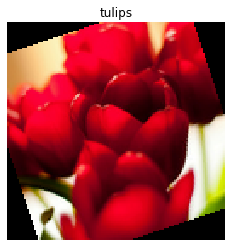

In [82]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

해당 함수를 `Dataset.map`와 함께 사용하는 것은  `Dataset.from_generator`와 함께 사용하는 것처럼 동일한 경고가 적용됩니다.<br>
해당 함수를 적용할 때, 타입과 반환 차원을 인자로 전달하는 것이 필요합니다.

In [83]:
def tf_random_torate_image(image, label):
    im_shape = image.shape
    [image, ] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


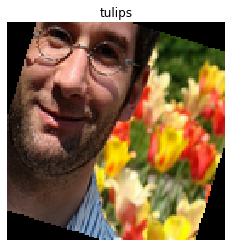

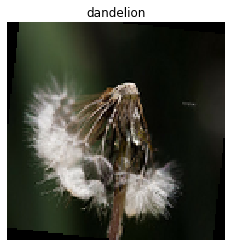

In [84]:
rot_ds = images_ds.map(tf_random_torate_image)

for image, label in rot_ds.take(2):
    show(image, label)

### `tf.Example` 프로토콜 버퍼 메시지 파싱하기

많은 입력 파이프라인들은 TFRecord 포맷으로부터 `tf.train.Example` 프로토콜 버퍼 메시지를 추출합니다.<br>
각 `tf.train.Example` 레코드는 하나 또는 그 이상의 "변수"를 포함하며, 입력 파이프라인은 일반적으로 해당 변수들을 텐서로 변환시킵니다.

In [85]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

`tf.data.Dataset`의 바깥에서 데이터를 이해하기 위해 `tf.train.Example` 프로토콜 버퍼를 사용할 수 있습니다.

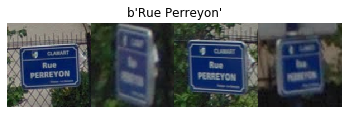

In [86]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature['image/text'].bytes_list.value[0])

In [87]:
raw_example = next(iter(dataset))

In [88]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg[tf.newaxis], {
            'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            'image/text'   : tf.io.FixedLenFeature(shape=(), dtype=tf.string)  
        })
    return example['image/encoded'][0], example['image/text'][0]

In [89]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), '...')

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [90]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [91]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])